# 1. Executive summary

The objective of this project will be to predict the value of the Ibovespa index. 
This index is followed by the main financial institutions in the country and is the thermometer of the Brazilian economy. 
It is composed of around 90 companies, to be part of the index companies must meet certain criteria, thus the index composition is periodically reviewed by the stock exchange (B3). Each company has a weight in the index related to its market cap, according to data released by B3 in March/2023, the companies with the greatest weight in the index are Vale, Itaú and Petrobras. The combination of the price of the shares that make up the index and the respective weight of each company, results in a value in points for the Ibovespa. 

To obtain historical data, it was initially planned to consult B3's own website, but historical information is better structured on the Yahoo Finance website. The period from Jan/11 to Feb/2023 was used.

Ibovespa Historical Data:

https://finance.yahoo.com/quote/%5EBVSP/history?period1=1294012800&period2=1677542400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

To complement the analysis, GDP, foreign investment and interest rate data obtained from The World Bank were used.
These data were extracted by API and correspond to the period from 2011 to 2021 (last year available for the indicators).

Annual macroeconomic data for Brazil:

https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.KD.ZG&country=BRA#

# 2. Methods

As the dataset used is a time series, some techniques will be applied to project Ibovespa:
- Model 1 - Forecast with Decomposition Models: using STLForecast with ARIMA Model.
- Model 2 - ARIMA Model (using autoARIMA)
- Model 3 - Decision Tree
- Model 4 - LSTM (Univariate)
- Model 5 - LSTM (Multivariate time series)

# 3. Libraries

In [1]:
#Importing Libraries

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import wbgapi as wb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
import datetime as dt
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.tree import DecisionTreeRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# 4. Data Understanding and preparation

## 4.1 The IBOVESPA Data Set

In [2]:
# Loading the index IBOVESPA Time Series (data from january/2011 to february 2023)
# The data was obtained from yahoo finance

ibov_df = pd.read_csv('C:/Users/natha/OneDrive/Escritorio/Berkeley/Capstone Project/Data/BVSP.csv')
ibov_df.shape

(3017, 7)

In [3]:
# Understanding the content of the dataset
# The target information will be "Close" (amount of index points at the end of the trading session)

ibov_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3012,2023-02-17,109941.0,109941.0,108968.0,109303.0,109303.0,10058400.0
3013,2023-02-22,109174.0,109174.0,106720.0,107152.0,107152.0,9356400.0
3014,2023-02-23,107152.0,108663.0,106731.0,107720.0,107720.0,11459000.0
3015,2023-02-24,107582.0,107611.0,105360.0,105873.0,105873.0,10221100.0
3016,2023-02-27,105807.0,106402.0,105227.0,105711.0,105711.0,9570700.0


In [4]:
# Understanding the content of the dataset
# It can be noticed that there are a few entries with null data

ibov_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3017 non-null   object 
 1   Open       3008 non-null   float64
 2   High       3008 non-null   float64
 3   Low        3008 non-null   float64
 4   Close      3008 non-null   float64
 5   Adj Close  3008 non-null   float64
 6   Volume     3008 non-null   float64
dtypes: float64(6), object(1)
memory usage: 165.1+ KB


In [5]:
# The Date is an object and need to be convert to datetime 

ibov_df['Date'] = pd.to_datetime(ibov_df['Date'])
ibov_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3017 non-null   datetime64[ns]
 1   Open       3008 non-null   float64       
 2   High       3008 non-null   float64       
 3   Low        3008 non-null   float64       
 4   Close      3008 non-null   float64       
 5   Adj Close  3008 non-null   float64       
 6   Volume     3008 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 165.1 KB


In [6]:
# Creating aditional columns de identify year and month. 
# The year field will be used to join this dataset with the macroeconomic dataset from the world bank

ibov_df['year'], ibov_df['month'] = ibov_df['Date'].dt.year, ibov_df['Date'].dt.month
ibov_df

,Date,Open,High,Low,Close,Adj Close,Volume,year,month
0,2011-01-03,69310.0,70471.0,69305.0,69962.0,69962.0,1862400.0,2011,1
1,2011-01-04,69962.0,70318.0,69560.0,70318.0,70318.0,2427200.0,2011,1
2,2011-01-05,70311.0,71173.0,69802.0,71091.0,71091.0,2309200.0,2011,1
3,2011-01-06,71093.0,71167.0,70469.0,70579.0,70579.0,2546000.0,2011,1
4,2011-01-07,70580.0,70783.0,69718.0,70057.0,70057.0,1761000.0,2011,1
...,...,...,...,...,...,...,...,...,...
3012,2023-02-17,109941.0,109941.0,108968.0,109303.0,109303.0,10058400.0,2023,2
3013,2023-02-22,109174.0,109174.0,106720.0,107152.0,107152.0,9356400.0,2023,2
3014,2023-02-23,107152.0,108663.0,106731.0,107720.0,107720.0,11459000.0,2023,2
3015,2023-02-24,107582.0,107611.0,105360.0,105873.0,105873.0,10221100.0,2023,2


In [7]:
# Checking percentage of missing values

missing_values = ibov_df.isna().mean().round(4) * 100
missing_values

Date         0.0
Open         0.3
High         0.3
Low          0.3
Close        0.3
Adj Close    0.3
Volume       0.3
year         0.0
month        0.0
dtype: float64

In [8]:
# As we have a very low percentage of missing information, these entries will be discarded

ibov_df = ibov_df.dropna().reset_index()
ibov_df.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume,year,month
3003,3012,2023-02-17,109941.0,109941.0,108968.0,109303.0,109303.0,10058400.0,2023,2
3004,3013,2023-02-22,109174.0,109174.0,106720.0,107152.0,107152.0,9356400.0,2023,2
3005,3014,2023-02-23,107152.0,108663.0,106731.0,107720.0,107720.0,11459000.0,2023,2
3006,3015,2023-02-24,107582.0,107611.0,105360.0,105873.0,105873.0,10221100.0,2023,2
3007,3016,2023-02-27,105807.0,106402.0,105227.0,105711.0,105711.0,9570700.0,2023,2


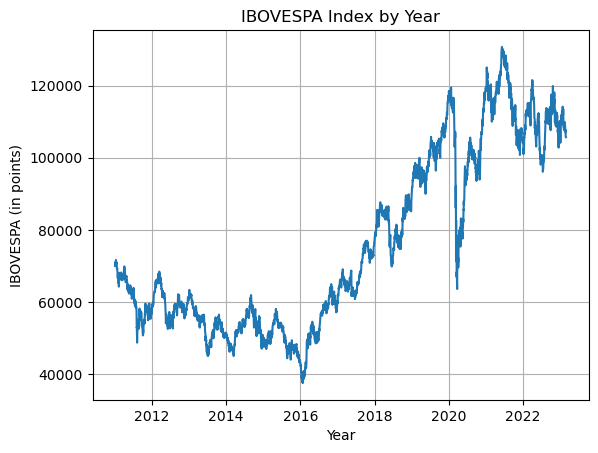

In [9]:
# Plotting the target (points at closing 'Close')

plt.plot(ibov_df["Date"], ibov_df["Close"])
plt.xlabel("Year")
plt.ylabel("IBOVESPA (in points)")
plt.title("IBOVESPA Index by Year")
plt.grid()
plt.show()

### Ibovespa highlights according to the chart above

In the graph above we can see that we have two points that deserve to be highlighted:

- In 2016, Brazil faced a year of political instability resulting in the impeachment of the president who was in government. This period was one of great volatility on the stock exchange due to market uncertainty.

- In the year 2020, with the explosion of cases of covid 19, the stock exchange had to trigger the circuit breaker 6 times in a period of 8 trading sessions. This procedure interrupts the trading of assets on the stock exchange at unusual market times. It is not possible to carry out trades on the exchange during this period.

From the graph we can also see that this time series is clearly not stationary

In [10]:
# Using Dickey-Fuller to confirm that the series is not stationary

def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   
ADF_test(ibov_df.Close)

Results of Dickey-Fuller Test:
Test Statistic                   -1.263448
p-value                           0.645725
Lags Used                        11.000000
Number of Observations Used    2996.000000
Critical Value (1%)              -3.432535
Critical Value (5%)              -2.862505
Critical Value (10%)             -2.567284
dtype: float64


 As the p-value is > 0.05, the time series is **not** stationary.

## 4.2 The World Bank Data (Brazil GDP, Foreign investment, Lending Interest Rate by year)

In [11]:
# Loading the data form The World Bank last 15 years

wb_df = wb.data.DataFrame(['NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.PP.KD','BX.KLT.DINV.WD.GD.ZS', 'BX.KLT.DINV.CD.WD','NY.GDP.MKTP.CD', 'FR.INR.LEND'], 'BRA', skipBlanks=True, columns='series',mrv = 15,index = 'time').reset_index()
wb_df['year'] = wb_df['time'].str.slice(2,6).astype(int)
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  15 non-null     object 
 1   BX.KLT.DINV.CD.WD     15 non-null     float64
 2   BX.KLT.DINV.WD.GD.ZS  15 non-null     float64
 3   FR.INR.LEND           15 non-null     float64
 4   NY.GDP.MKTP.CD        15 non-null     float64
 5   NY.GDP.MKTP.KD.ZG     15 non-null     float64
 6   NY.GDP.PCAP.PP.KD     15 non-null     float64
 7   year                  15 non-null     int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 1.0+ KB


In [12]:
# Renaming the columns

wb_df.rename(columns = {'BX.KLT.DINV.CD.WD':'Foreign_direct_investment','BX.KLT.DINV.WD.GD.ZS':'Foreign_direct_investment_GDP'
                     , 'FR.INR.LEND':'Lending_interest_rate','NY.GDP.MKTP.CD':'GDP_Current','NY.GDP.MKTP.KD.ZG':'GDP_Growth',
                     'NY.GDP.PCAP.PP.KD':'GDP_Per_Capita'}, inplace = True)
wb_df

,time,Foreign_direct_investment,Foreign_direct_investment_GDP,Lending_interest_rate,GDP_Current,GDP_Growth,GDP_Per_Capita,year
0,YR2007,4.457949e+10,3.190895,43.716667,1.397084e+12,6.069871,13518.847776,2007
1,YR2008,5.071640e+10,2.990663,47.250000,1.695825e+12,5.094195,14067.945813,2008
2,YR2009,3.148093e+10,1.888456,44.650000,1.667020e+12,-0.125812,13916.963225,2009
3,YR2010,8.238993e+10,3.729956,39.991667,2.208872e+12,7.528226,14824.741154,2010
4,YR2011,1.024272e+11,3.915112,43.883333,2.616202e+12,3.974423,15271.469352,2011
5,YR2012,9.256839e+10,3.755022,36.636667,2.465189e+12,1.921176,15425.352929,2012
6,YR2013,7.521103e+10,3.041525,27.391667,2.472807e+12,3.004823,15751.484448,2013
7,YR2014,8.771398e+10,3.571426,32.008333,2.455994e+12,0.503956,15695.643104,2014
8,YR2015,6.473815e+10,3.592145,43.958333,1.802214e+12,-3.545763,15011.577194,2015
9,YR2016,7.429463e+10,4.137363,52.100000,1.795700e+12,-3.275917,14402.494008,2016


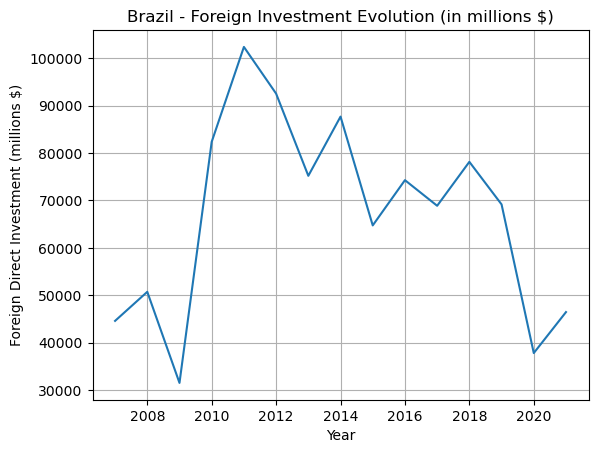

In [13]:
# Plotting the Foreign Direct Investment Evolution in Brazil in the last 15 years

plt.plot(wb_df['year'], wb_df['Foreign_direct_investment']/1000000, label = "Foreign_direct_investment")
plt.title('Brazil - Foreign Investment Evolution (in millions $)')
plt.xlabel("Year")
plt.ylabel("Foreign Direct Investment (millions $)")
plt.grid()
plt.show()


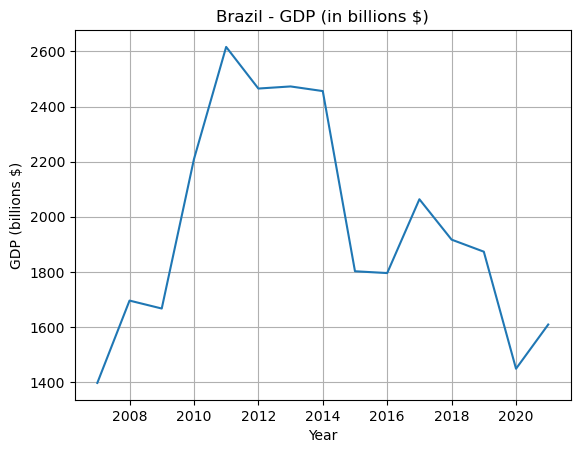

In [14]:
# Plotting the Brazil's GDP Evolution in the last 15 years

plt.plot(wb_df['year'], wb_df['GDP_Current']/1000000000, label = "GDP_Current")
plt.xlabel("Year")
plt.ylabel("GDP (billions $)")
plt.title('Brazil - GDP (in billions $)')
plt.grid()
plt.show()

### GDP vs Foreign Direct Investment

Looking at the evolution of GDP and foreign direct investment, it is noted that in periods of GDP growth there is also more inflow of foreign investment. As expected, high GDP generates financial stability and international markets tend to have more confidence in the economy and invest in Brazil.

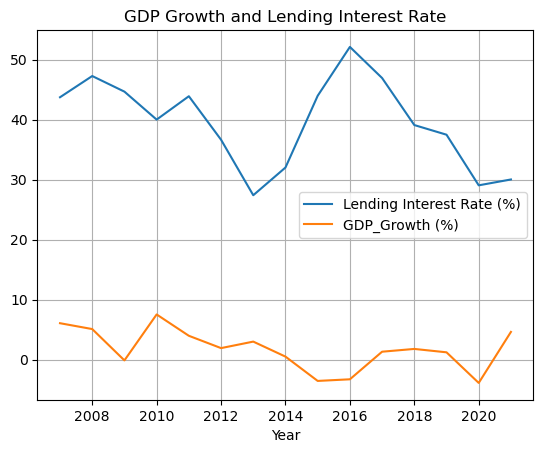

In [15]:
# Plotting the Brazil's GDP Growth and Lending Interest Rate in the last 15 years

plt.plot(wb_df['year'], wb_df['Lending_interest_rate'], label = "Lending Interest Rate (%)")
plt.plot(wb_df['year'], wb_df['GDP_Growth'], label = "GDP_Growth (%)")
plt.xlabel("Year")
plt.title('GDP Growth and Lending Interest Rate')
plt.grid()
plt.legend()
plt.show()


### GDP Growth and the Lending Interest Rate 

Brazil is known as a country that practices high interest rates as a means of controlling inflation. As we can see from the graph in a period of rising loan rates, GDP tends to fall, given that high interest rates are generally barriers to economic growth, as "more expensive money" results in less investment.

### Conclusion

All these macroeconomic factors influence the behavior of local and international investors, which generates periods of high volatility in the market, especially in developing countries like Brazil.

#  5. Modeling

## 5.1 Model 01 | STLForecast with ARIMA | Univariate time series

In this model the decomposition of the time series into seasonal and trend components was applied and thus time series for forecasting using ARIMA (**STLForecast with ARIMA**).
In this model, only the dataset with information of points at close (dataset with the historical of Ibovespa) was used.
This way, a univariate time series forecasting was performed.

In [16]:
# Copying the dataset with another name to preserve the original dataset

ibov_stl = ibov_df.copy(deep=True)
ibov_stl.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,year,month
0,0,2011-01-03,69310.0,70471.0,69305.0,69962.0,69962.0,1862400.0,2011,1
1,1,2011-01-04,69962.0,70318.0,69560.0,70318.0,70318.0,2427200.0,2011,1
2,2,2011-01-05,70311.0,71173.0,69802.0,71091.0,71091.0,2309200.0,2011,1
3,3,2011-01-06,71093.0,71167.0,70469.0,70579.0,70579.0,2546000.0,2011,1
4,4,2011-01-07,70580.0,70783.0,69718.0,70057.0,70057.0,1761000.0,2011,1


In [17]:
# Keeping only the columns of interest for this analysis 

ibov_stl.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'year', 'month','index'], axis = 1, inplace = True)
ibov_stl.head()

,Date,Close
0,2011-01-03,69962.0
1,2011-01-04,70318.0
2,2011-01-05,71091.0
3,2011-01-06,70579.0
4,2011-01-07,70057.0


In [18]:
# Checking the treated file to ensure that the columns were deleted correctly and that the information remains intact

ibov_stl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3008 non-null   datetime64[ns]
 1   Close   3008 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.1 KB


In [19]:
# Setting the date as the index of the dataframe

ibov_stl.set_index(pd.to_datetime(ibov_stl.Date),inplace=True) 
ibov_stl.drop('Date', axis = 1, inplace = True)
ibov_stl[-5:]

,Close
Date,
2023-02-17,109303.0
2023-02-22,107152.0
2023-02-23,107720.0
2023-02-24,105873.0
2023-02-27,105711.0


In [20]:
# Splitting the data set into training and testing

y_hist = ibov_stl[:'03-28-2019'] #Train data set
y_future = ibov_stl['03-28-2019':] #Test data set

In [21]:
y_future # The test data set has 974 entries (around 32 % of the total entries)

,Close
Date,
2019-03-28,94389.0
2019-03-29,95415.0
2019-04-01,96054.0
2019-04-02,95387.0
2019-04-03,94491.0
...,...
2023-02-17,109303.0
2023-02-22,107152.0
2023-02-23,107720.0


This period of training and test was chosen thinking about preventing the beginning of 2020 (atypical period due to the pandemic) from contaminating the training sample. It will also be important to check how the model predicts this period of high volatility.

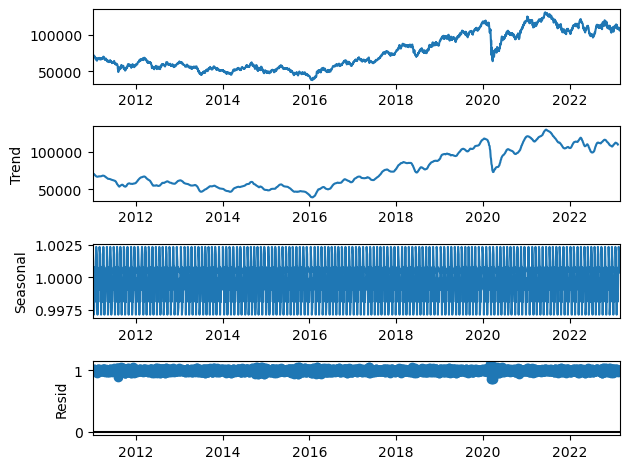

In [22]:
# Decomposing the time series
# As the period of the time series is not well defined, it was used approximately the number of trading days in a month

result = seasonal_decompose(ibov_stl, model='multiplicative', period=20) 
fig_result_add = result.plot()

We can see from the graph above the growth trend, with the exception of the periods of 2016 and 2020 already highlighted and explained previously.

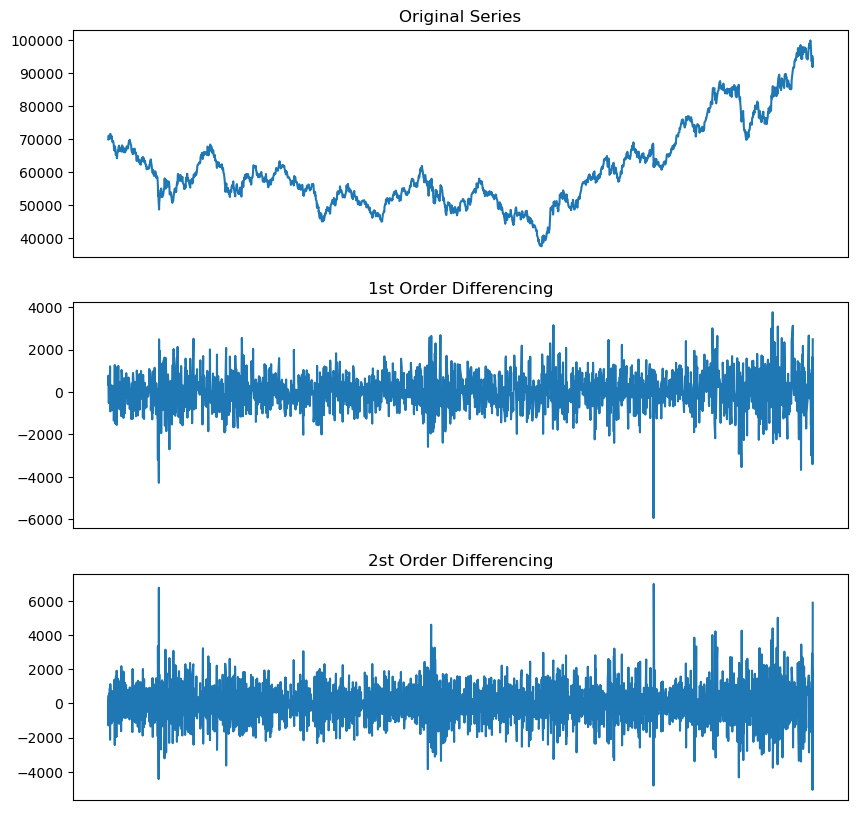

In [23]:
# Finding the order of the model

# Original Series
fig, (ax1, ax2,ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(y_hist)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(y_hist.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2st Differencing
ax3.plot(y_hist.diff().diff())
ax3.set_title('2st Order Differencing')
ax3.axes.xaxis.set_visible(False)


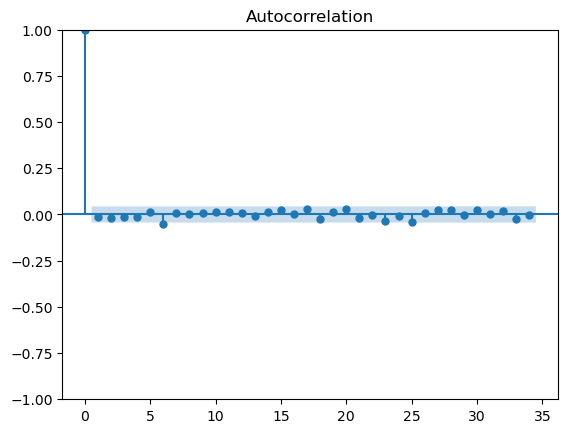

In [24]:
acf_plot = sm.graphics.tsa.plot_acf(y_hist.diff().dropna())

C:\Users\natha\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


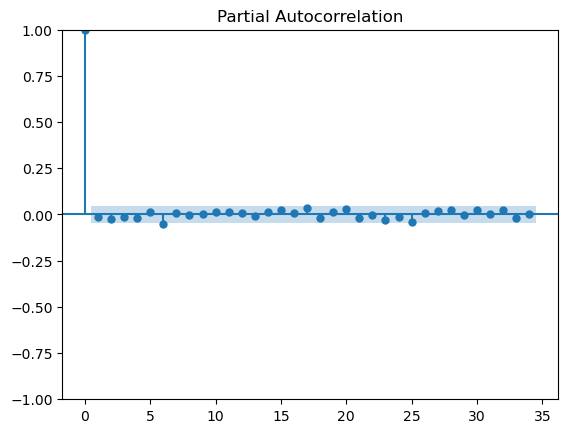

In [25]:
pacf_plot = sm.graphics.tsa.plot_pacf(y_hist.diff().dropna())

In the graphs of ACF and PACF we can verify that the first lag is the most significant.
Thus, we consider “p” (PACF) and "q" (ACF) to be 1.
The parameter "d" is also 1 because the series becomes stationary after the first differentiation.

In [26]:
# Training the model

stl = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 1), 'trend':"t"}, period = 20)
stl_results = stl.fit()
forecast_stl = stl_results.forecast(len(y_future))

C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
# Transforming the projections into a dataframe and resetting the index. 
# This will be done to merge projections and real data in a single dataset.

predictions_stl = forecast_stl.to_frame(name="Preds")
predictions_stl = predictions_stl.reset_index()
predictions_stl

,index,Preds
0,2035,95157.375340
1,2036,94847.367396
2,2037,94182.826696
3,2038,94049.400445
4,2039,93842.167960
...,...,...
969,3004,107545.682203
970,3005,107716.822135
971,3006,109190.998002
972,3007,108732.277018


In [28]:
# Resetting the index of the y_future and storing in the real_values dataset

real_values_stl = y_future
real_values_stl = real_values_stl.reset_index()
real_values_stl

,Date,Close
0,2019-03-28,94389.0
1,2019-03-29,95415.0
2,2019-04-01,96054.0
3,2019-04-02,95387.0
4,2019-04-03,94491.0
...,...,...
969,2023-02-17,109303.0
970,2023-02-22,107152.0
971,2023-02-23,107720.0
972,2023-02-24,105873.0


In [29]:
# Merging the predictions and the real values in the same dataframe to facilitate data manipulation and plotting

stl_result = pd.merge(real_values_stl, predictions_stl, left_index=True, right_index=True)

In [30]:
# Setting the date as index

stl_result.set_index(pd.to_datetime(stl_result.Date),inplace=True) 
stl_result.drop('Date', axis = 1, inplace = True)
stl_result

,Close,index,Preds
Date,,,
2019-03-28,94389.0,2035,95157.375340
2019-03-29,95415.0,2036,94847.367396
2019-04-01,96054.0,2037,94182.826696
2019-04-02,95387.0,2038,94049.400445
2019-04-03,94491.0,2039,93842.167960
...,...,...,...
2023-02-17,109303.0,3004,107545.682203
2023-02-22,107152.0,3005,107716.822135
2023-02-23,107720.0,3006,109190.998002


In [31]:
# Evaluating model quality

pred_error = stl_result.Close - stl_result.Preds
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
mape = mean_absolute_percentage_error(stl_result.Close, stl_result.Preds)

print(f'MODEL: STL Forecast with ARIMA')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


MODEL: STL Forecast with ARIMA
MAE: 9804.081939810932
RMSE: 12380.873424658113
MAPE: 0.09084429616081456


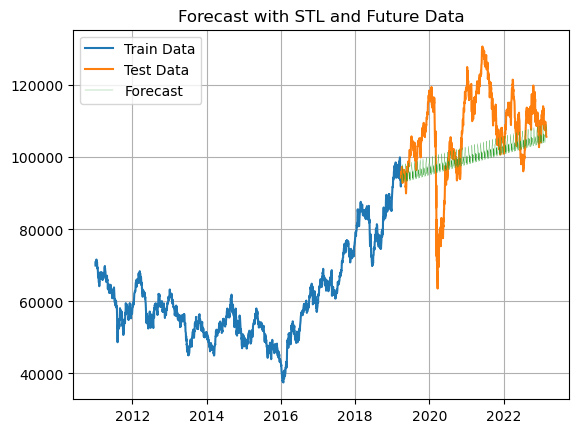

In [32]:
# Plotting the results

plt.plot(y_hist, label = 'Train Data')
plt.plot(y_future, label = 'Test Data')
plt.plot(stl_result.Preds, label = 'Forecast', linewidth=0.2)
plt.title('Forecast with STL and Future Data')
plt.grid();
plt.legend()

From the results shown above, we can conclude that although simple, this ARIMA decomposition model performed relatively well with a MAPE around 0.09.
As 2020 was a rather atypical period, this hindered the model from being more accurate.
With this model we can generate a long prediction interval from a single training sample. Its implementation is relatively simple since it only requires the number of future periods (steps) for predicting value.
Remembering that the longer the projection period, the greater the error.

## 5.2 Model 02 | ARIMA with AutoARIMA | Univariate time series

In this model, the **ARIMA** method was applied, using **autoARIMA** to find the best p, d and q parameters.
The period to be considered in the training sample was also modified to evaluate how the model behaves by including the year 2020 in the training.

In [33]:
# Copying the dataset with another name to preserve the original dataset

ibov_arima = ibov_df.copy(deep=True)
ibov_arima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      3008 non-null   int64         
 1   Date       3008 non-null   datetime64[ns]
 2   Open       3008 non-null   float64       
 3   High       3008 non-null   float64       
 4   Low        3008 non-null   float64       
 5   Close      3008 non-null   float64       
 6   Adj Close  3008 non-null   float64       
 7   Volume     3008 non-null   float64       
 8   year       3008 non-null   int64         
 9   month      3008 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 235.1 KB


In [34]:
# Setting the date as the index of the dataframe

ibov_arima.set_index(pd.to_datetime(ibov_arima.Date),inplace=True) 
ibov_arima.drop('Date', axis = 1, inplace = True)
ibov_arima[-5:]

,index,Open,High,Low,Close,Adj Close,Volume,year,month
Date,,,,,,,,,
2023-02-17,3012,109941.0,109941.0,108968.0,109303.0,109303.0,10058400.0,2023,2
2023-02-22,3013,109174.0,109174.0,106720.0,107152.0,107152.0,9356400.0,2023,2
2023-02-23,3014,107152.0,108663.0,106731.0,107720.0,107720.0,11459000.0,2023,2
2023-02-24,3015,107582.0,107611.0,105360.0,105873.0,105873.0,10221100.0,2023,2
2023-02-27,3016,105807.0,106402.0,105227.0,105711.0,105711.0,9570700.0,2023,2


In [35]:
# Splitting the data set into training and testing
# As the beginning of 2020, especially from March, were months of atypical decline in stock prices, 
# in this model, this year was included in the training sample to assess how the model performs.

ibov_train = ibov_arima[:'01-01-2022'] #Train data set
ibov_test = ibov_arima['01-01-2022':] #Test data set
ibov_test

,index,Open,High,Low,Close,Adj Close,Volume,year,month
Date,,,,,,,,,
2022-01-03,2728,104823.0,106125.0,103413.0,103922.0,103922.0,11128500.0,2022,1
2022-01-04,2729,103922.0,104276.0,103096.0,103514.0,103514.0,11491600.0,2022,1
2022-01-05,2730,103514.0,103514.0,100850.0,101006.0,101006.0,0.0,2022,1
2022-01-06,2731,101006.0,102235.0,101000.0,101561.0,101561.0,11749200.0,2022,1
2022-01-07,2732,101561.0,102719.0,101104.0,102719.0,102719.0,11733200.0,2022,1
...,...,...,...,...,...,...,...,...,...
2023-02-17,3012,109941.0,109941.0,108968.0,109303.0,109303.0,10058400.0,2023,2
2023-02-22,3013,109174.0,109174.0,106720.0,107152.0,107152.0,9356400.0,2023,2
2023-02-23,3014,107152.0,108663.0,106731.0,107720.0,107720.0,11459000.0,2023,2


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46143.594, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46167.708, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46144.725, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46146.532, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46166.029, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=46143.595, Time=1.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46143.318, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=46141.318, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=46143.332, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=46145.495, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=46139.692, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=46144.974, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=46141.692, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=46141.706, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0

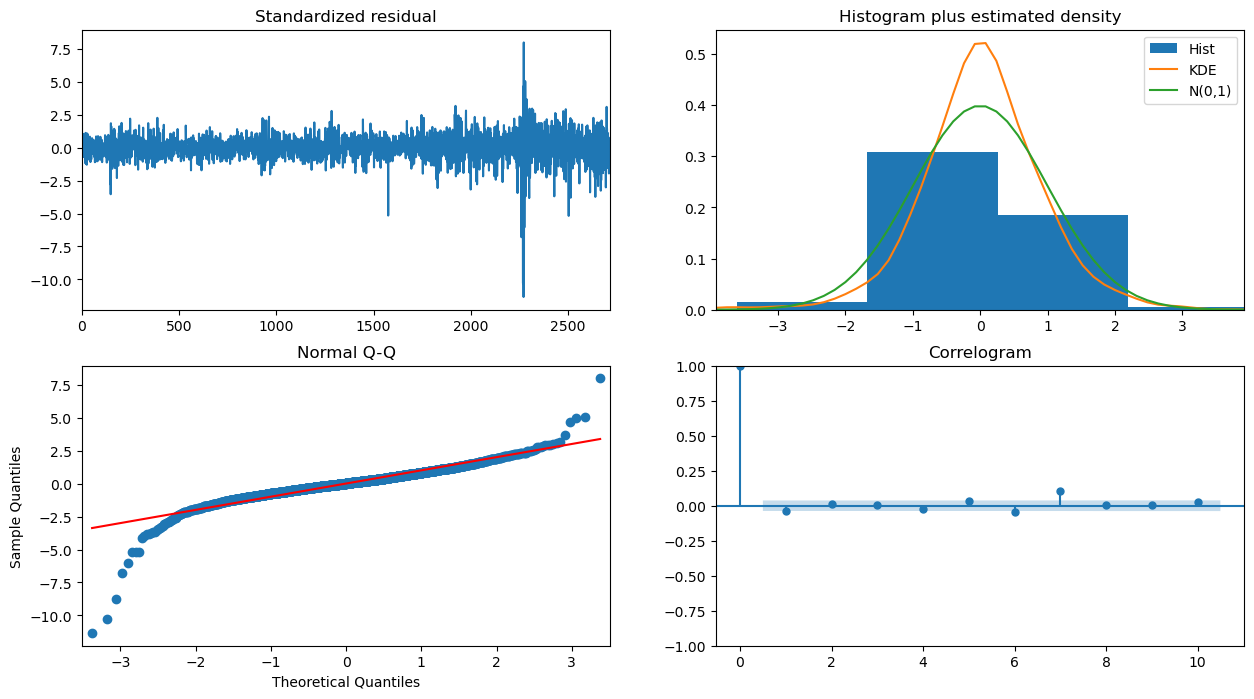

In [36]:
# Performin autoARIMA to find the bests p, d and q

model_autoARIMA = auto_arima(ibov_train.Close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [37]:
# Training and fitting the model with the order proposed by autoarima

arima = sm.tsa.arima.ARIMA(ibov_train['Close'].astype(np.float64), order = (0,1,2))
arima_model = arima.fit() 
arima_model.summary()

C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2719
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -23066.846
Date:                Mon, 27 Mar 2023   AIC                          46139.692
Time:                        22:33:16   BIC                          46157.415
Sample:                             0   HQIC                         46146.099
                               - 2719                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0753      0.005    -14.130      0.000      -0.086      -0.065
ma.L2          0.0439      0.006      6.811      0.000       0.031       0.057
sigma2      1.374e+06   1.25e+04    109.849      0.000    1.35e+06     1.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):             31155.99
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               4.58   Skew:                            -1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
fc = arima_model.forecast(289) # Predicting for 289 dates length ibov_test (from january 2022 until february 2023)
predictions_arima = fc.to_frame(name="Preds")  # Transforming the projections into a dataframe and resetting the index. 
predictions_arima = predictions_arima.reset_index()
predictions_arima

C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,index,Preds
0,2719,104734.464407
1,2720,104764.283666
2,2721,104764.283666
3,2722,104764.283666
4,2723,104764.283666
...,...,...
284,3003,104764.283666
285,3004,104764.283666
286,3005,104764.283666
287,3006,104764.283666


In [39]:
# Resetting the index of the ibov_test and storing in the real_values dataset

real_values_arima = ibov_test
real_values_arima = real_values_arima.reset_index()
real_values_arima

,Date,index,Open,High,Low,Close,Adj Close,Volume,year,month
0,2022-01-03,2728,104823.0,106125.0,103413.0,103922.0,103922.0,11128500.0,2022,1
1,2022-01-04,2729,103922.0,104276.0,103096.0,103514.0,103514.0,11491600.0,2022,1
2,2022-01-05,2730,103514.0,103514.0,100850.0,101006.0,101006.0,0.0,2022,1
3,2022-01-06,2731,101006.0,102235.0,101000.0,101561.0,101561.0,11749200.0,2022,1
4,2022-01-07,2732,101561.0,102719.0,101104.0,102719.0,102719.0,11733200.0,2022,1
...,...,...,...,...,...,...,...,...,...,...
284,2023-02-17,3012,109941.0,109941.0,108968.0,109303.0,109303.0,10058400.0,2023,2
285,2023-02-22,3013,109174.0,109174.0,106720.0,107152.0,107152.0,9356400.0,2023,2
286,2023-02-23,3014,107152.0,108663.0,106731.0,107720.0,107720.0,11459000.0,2023,2
287,2023-02-24,3015,107582.0,107611.0,105360.0,105873.0,105873.0,10221100.0,2023,2


In [40]:
# Merging the predictions and the real values in the same dataframe to facilitate data manipulation and plotting

arima_result = pd.merge(real_values_arima, predictions_arima, left_index=True, right_index=True)

In [41]:
# Setting the date as index

arima_result.set_index(pd.to_datetime(arima_result.Date),inplace=True) 
arima_result.drop('Date', axis = 1, inplace = True)
arima_result

,index_x,Open,High,Low,Close,Adj Close,Volume,year,month,index_y,Preds
Date,,,,,,,,,,,
2022-01-03,2728,104823.0,106125.0,103413.0,103922.0,103922.0,11128500.0,2022,1,2719,104734.464407
2022-01-04,2729,103922.0,104276.0,103096.0,103514.0,103514.0,11491600.0,2022,1,2720,104764.283666
2022-01-05,2730,103514.0,103514.0,100850.0,101006.0,101006.0,0.0,2022,1,2721,104764.283666
2022-01-06,2731,101006.0,102235.0,101000.0,101561.0,101561.0,11749200.0,2022,1,2722,104764.283666
2022-01-07,2732,101561.0,102719.0,101104.0,102719.0,102719.0,11733200.0,2022,1,2723,104764.283666
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17,3012,109941.0,109941.0,108968.0,109303.0,109303.0,10058400.0,2023,2,3003,104764.283666
2023-02-22,3013,109174.0,109174.0,106720.0,107152.0,107152.0,9356400.0,2023,2,3004,104764.283666
2023-02-23,3014,107152.0,108663.0,106731.0,107720.0,107720.0,11459000.0,2023,2,3005,104764.283666


In [42]:
# Evaluating model quality

pred_error = arima_result.Close - arima_result.Preds
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
mape = mean_absolute_percentage_error(arima_result.Close, arima_result.Preds)

print(f'MODEL: ARIMA WITH AUTO ARIMA')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MODEL: ARIMA WITH AUTO ARIMA
MAE: 6307.398857594435
RMSE: 7229.783306517954
MAPE: 0.0565395046286158


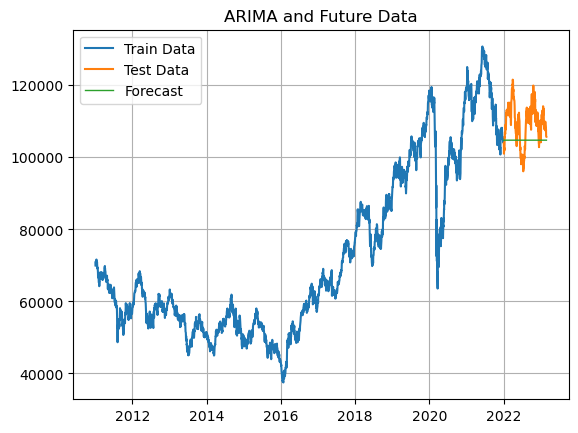

In [43]:
# Plotting the results

plt.plot(ibov_train.Close, label = 'Train Data')
plt.plot(ibov_test.Close, label = 'Test Data')
plt.plot(arima_result.Preds, label = 'Forecast', linewidth=1)
plt.title('ARIMA and Future Data')
plt.grid();
plt.legend()

This model performed well, including the year 2020 in the training sample softened the effects of the pandemic.
However, for most of the projected days, the projection was below the actual one, indicating an undervaluation of the shares that make up the IBOVESPA.
Like model 01, this model also only requires the number of days you want to project to be implemented.


## 5.3 Model 03 | Decision Tree | Univariate time series

In this analysis, a regression model with a decision tree was applied. This type of model has a huge advantage with regard to its interpretability. The same training period applied in model 2 was used in this model.

In [58]:
# Checking if the original file is preserved

ibov_df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,year,month
0,0,2011-01-03,69310.0,70471.0,69305.0,69962.0,69962.0,1862400.0,2011,1
1,1,2011-01-04,69962.0,70318.0,69560.0,70318.0,70318.0,2427200.0,2011,1
2,2,2011-01-05,70311.0,71173.0,69802.0,71091.0,71091.0,2309200.0,2011,1
3,3,2011-01-06,71093.0,71167.0,70469.0,70579.0,70579.0,2546000.0,2011,1
4,4,2011-01-07,70580.0,70783.0,69718.0,70057.0,70057.0,1761000.0,2011,1


In [59]:
# Copying the dataset with another name to preserve the original dataset

ibov_dtree = ibov_df.copy(deep=True)
ibov_dtree.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,year,month
0,0,2011-01-03,69310.0,70471.0,69305.0,69962.0,69962.0,1862400.0,2011,1
1,1,2011-01-04,69962.0,70318.0,69560.0,70318.0,70318.0,2427200.0,2011,1
2,2,2011-01-05,70311.0,71173.0,69802.0,71091.0,71091.0,2309200.0,2011,1
3,3,2011-01-06,71093.0,71167.0,70469.0,70579.0,70579.0,2546000.0,2011,1
4,4,2011-01-07,70580.0,70783.0,69718.0,70057.0,70057.0,1761000.0,2011,1


In [60]:
# Creating a series with only the target column

dtree_short = ibov_dtree['Close']
dtree_short.tail()

3003    109303.0
3004    107152.0
3005    107720.0
3006    105873.0
3007    105711.0
Name: Close, dtype: float64

In [61]:
# Converting to dataframe and resetting the index

dtree_short = pd.DataFrame(dtree_short).reset_index()
dtree_short = dtree_short.drop(columns = ['index'])
dtree_short

,Close
0,69962.0
1,70318.0
2,71091.0
3,70579.0
4,70057.0
...,...
3003,109303.0
3004,107152.0
3005,107720.0
3006,105873.0


In [62]:
# in this model we are going to predict a period of 289 days, from jan/2022 to feb/2023
future_days = 289

# Creating a Prediction column, shifting up 289 days
dtree_short['Prediction'] = dtree_short['Close'].shift(-future_days)
dtree_short

,Close,Prediction
0,69962.0,66964.0
1,70318.0,65114.0
2,71091.0,66017.0
3,70579.0,66908.0
4,70057.0,66704.0
...,...,...
3003,109303.0,NaN
3004,107152.0,NaN
3005,107720.0,NaN
3006,105873.0,NaN


In [63]:
# creating an array with the Close value

X = np.array(dtree_short.drop(['Prediction'], 1))[:-future_days]
print(len(X))

2719


C:\Users\natha\AppData\Local\Temp\ipykernel_24100\3068257102.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(dtree_short.drop(['Prediction'], 1))[:-future_days]


In [64]:
# creating an array with the 'target' obtained by shifting the column close

y = np.array(dtree_short['Prediction'])[:-future_days]
print(len(y))

2719


In [65]:
# Splitting de train and test data

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [66]:
# Training the decision regressor

tree = DecisionTreeRegressor().fit(x_train, y_train)


In [67]:
# Creating the array with the value of the input to get the prediction

x_future = dtree_short.drop(['Prediction'], 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)
x_future

C:\Users\natha\AppData\Local\Temp\ipykernel_24100\1944079369.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_future = dtree_short.drop(['Prediction'], 1)[:-future_days]


array([[ 95369.],
       [ 96582.],
       [ 93952.],
       [ 95587.],
       [ 97811.],
       [100774.],
       [100799.],
       [103913.],
       [105351.],
       [104532.],
       [102175.],
       [104512.],
       [106430.],
       [107229.],
       [106483.],
       [106517.],
       [107379.],
       [109786.],
       [110133.],
       [110227.],
       [110575.],
       [108888.],
       [111335.],
       [111814.],
       [112919.],
       [113682.],
       [113625.],
       [113571.],
       [112722.],
       [114992.],
       [115323.],
       [114975.],
       [116146.],
       [117947.],
       [118157.],
       [117679.],
       [116016.],
       [116348.],
       [117857.],
       [119051.],
       [119475.],
       [119306.],
       [118558.],
       [119223.],
       [119851.],
       [121956.],
       [125077.],
       [122807.],
       [123998.],
       [122040.],
       [123481.],
       [120502.],
       [121242.],
       [120673.],
       [119708.],
       [11

In [68]:
# Predicting 289 days

tree_prediction = tree.predict(x_future)
tree_prediction



array([103922. , 117165. , 101006. , 101561. , 102719. , 103779. ,
       103779. , 105686. , 117947. , 107229. , 106692. , 106522. ,
       108013. , 109102. , 108942. , 107752. , 109845. , 122040. ,
       112315. , 111478. , 112388. , 113147. , 105135. , 111696. ,
       112245. , 111996. , 112234. , 112461. , 113359. , 113572. ,
       113807. , 120530. , 115181. , 113528. , 112768. , 111725. ,
       120260. , 112008. , 111592. , 113142. , 115174. , 115166. ,
       114474. , 111593. , 111203. , 113900. , 113663. , 111713. ,
       109928. , 108959. , 111112. , 113076. , 115311. , 116155. ,
       117272. , 116953. , 113624. , 119081. , 118738. , 120014. ,
       120260. , 119999. , 121570. , 121280. , 118885. , 118228. ,
       114781. , 118322. , 116953. , 111593. , 116782. , 105481. ,
       115687. , 115057. , 114344. , 111078. , 120934. , 108213. ,
       109349. , 109919. , 107876. , 106639. , 106528. , 108344. ,
       105304. , 105135. , 113359. , 103110. , 104397. , 10568

In [69]:
# Creating a dataframe with the input (close points in the past) and output of the model (predicitons)

predictions = tree_prediction 
valid = dtree_short[X.shape[0]:]
valid['Predictions'] = predictions


C:\Users\natha\AppData\Local\Temp\ipykernel_24100\2111356004.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


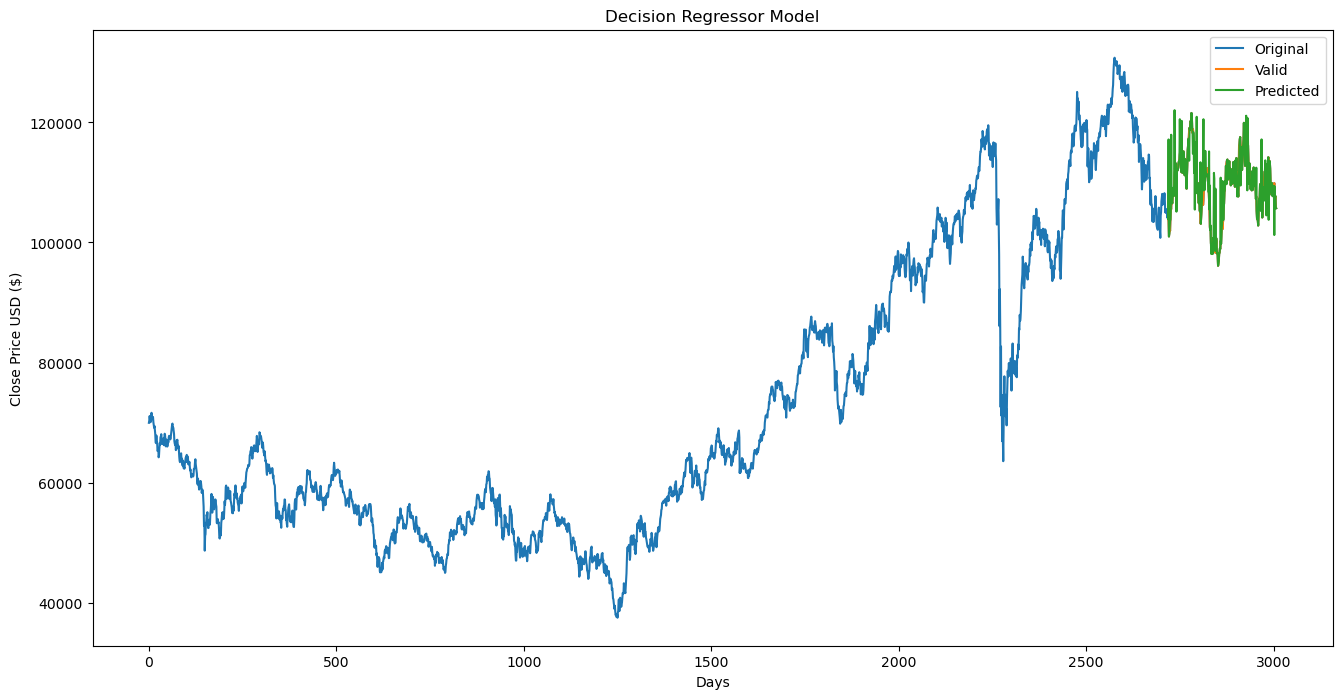

In [70]:
plt.figure(figsize=(16,8))
plt.title("Decision Regressor Model")
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(dtree_short['Close'])
plt.plot(valid[[ 'Close','Predictions']])
plt.legend(["Original", "Valid", 'Predicted'])
plt.show()

In [71]:
# Evaluating model quality

pred_error = valid['Close'] - valid['Predictions']
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
mape = mean_absolute_percentage_error(valid['Close'],  valid['Predictions'])

print(f'MODEL: DECISION TREE REGRESSOR')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MODEL: DECISION TREE REGRESSOR
MAE: 1086.916955017301
RMSE: 3013.8405222857473
MAPE: 0.010022749431273716


This tree was trained to forecast 289 days into the future, from Jan/22 to Feb/23, approximately one year of forecast considering trading days.
However, to train a regression model using a tree we need an input variable and an output variable. In the case of a univariate time series we have only one variable which is the target variable itself.
To separate this target variable into input and output, the series data itself was used (the close value "in the past" days).
In my opinion, this method makes the model interpretability worse (which would be one of the great advantages of the tree). The results were good because they are not totally out of sample. We still don't have another period of 289 days to compare the results with a period completely outside of the training data, because of the shift process. 
A next step to improve this model would be to use a shorter projection period to be able to test performance on a 100% sample outside of training. Another way to improve the tree would be to use other variables so that the model does not depend only on the history of the target variable.
This model has good results and is easy to implement, but for long periods of projection it requires longer historical series. Therefore, my recommendation would be to use it only for short-term projections.

## 5.4 Model 04 | LSTM | Univariate time series

In this model a neural network architecture was used. This methodology is extremely robust for temporal series processing but needs more machine processing. The use or not of this type of model should always take this into consideration.

In [72]:
# Copying the dataset with another name to preserve the original dataset

ibov_lstm = ibov_df.copy(deep=True)
ibov_lstm.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,year,month
0,0,2011-01-03,69310.0,70471.0,69305.0,69962.0,69962.0,1862400.0,2011,1
1,1,2011-01-04,69962.0,70318.0,69560.0,70318.0,70318.0,2427200.0,2011,1
2,2,2011-01-05,70311.0,71173.0,69802.0,71091.0,71091.0,2309200.0,2011,1
3,3,2011-01-06,71093.0,71167.0,70469.0,70579.0,70579.0,2546000.0,2011,1
4,4,2011-01-07,70580.0,70783.0,69718.0,70057.0,70057.0,1761000.0,2011,1


In [73]:
# Cleaning the data and setting the date as index

Y = ibov_lstm.drop(columns = ['index','Open', 'High', 'Low', 'Adj Close','Volume','year', 'month'])
Y.set_index(pd.to_datetime(Y.Date),inplace=True) 
Y.drop('Date', axis = 1, inplace = True)
Y.tail()

,Close
Date,
2023-02-17,109303.0
2023-02-22,107152.0
2023-02-23,107720.0
2023-02-24,105873.0
2023-02-27,105711.0


(array([14610., 15340., 16071., 16801., 17532., 18262., 18993., 19723.]),
 [Text(14610.0, 0, '2010'),
  Text(15340.0, 0, '2012'),
  Text(16071.0, 0, '2014'),
  Text(16801.0, 0, '2016'),
  Text(17532.0, 0, '2018'),
  Text(18262.0, 0, '2020'),
  Text(18993.0, 0, '2022'),
  Text(19723.0, 0, '2024')])

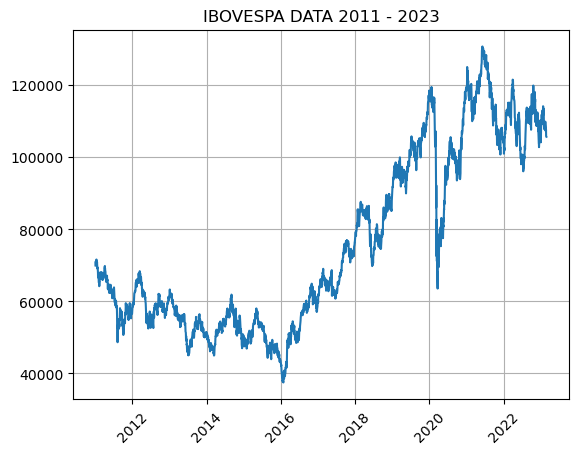

In [74]:
# Plotting the data to ckeck if the data is preserved

plt.plot(Y)
plt.title('IBOVESPA DATA 2011 - 2023')
plt.grid();
plt.xticks(rotation=45)


In [75]:
# Setting the start and end of the time series and scaling the features

start = dt.datetime(2011,1,3)
end = dt.datetime(2023,2,27)
Y_array = Y['Close'].values
Y_array = MinMaxScaler(feature_range=(0,1)).fit_transform(Y_array.reshape(-1,1))
Y_array.shape

(3008, 1)

In [76]:
# Defining the training size

train_size = int(len(Y_array)*0.8)
train_size

2406

In [77]:
# Reseting the index

data = Y.reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3008 non-null   datetime64[ns]
 1   Close   3008 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.1 KB


In [78]:
# Spliting in training and test

train_size = int(len(data)*0.8)
test_size = len(data)-train_size
train = data.iloc[:train_size].drop('Date', axis =1)
test = data.iloc[train_size:].drop('Date', axis =1)
test_size

602

In [79]:
# Scaling the train and test samples

scaler = MinMaxScaler().fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [80]:
# Looking back 20 days is more than enough to predict the next step given the 
# volatility of the actions that make up the index, in a period of one month of negotiation
# The batch size chosen was 16 so as not to overload processing/memory

look_back = 20
train_data_gen = TimeseriesGenerator (train_scaled,train_scaled,length = look_back,batch_size = 16)
test_data_gen = TimeseriesGenerator (test_scaled,test_scaled,length = look_back,batch_size = 16)

In [81]:
# Training the model
# Return Sequences equal true: return the hidden state output for each input time step
# For Recurrent Neural Network the activation function Tanh is more common
# 5 LSTM blocks or neurons and 20 epochs because of required computing processing

model_lstm = Sequential([LSTM(5, return_sequences = True, activation = 'tanh'),Flatten(),Dense(1)])
model_lstm.compile(loss="mse", optimizer="rmsprop",metrics = ['mae'])
history = model_lstm.fit(train_data_gen, validation_data = test_data_gen, epochs=20,verbose=0)

In [82]:
# Predicting and saving the results as dataframe format

preds = model_lstm.predict(test_data_gen)
preds = scaler.inverse_transform(preds)
preds = pd.DataFrame(preds, columns=['Close'])

37/37 [==============================] - 1s 3ms/step


In [83]:
# Setting an index to results

preds.index = test.index[look_back:]

In [84]:
#Checking the results

preds.head

<bound method NDFrame.head of               Close
2426  100017.820312
2427  100486.109375
2428  100943.710938
2429  101581.304688
2430  101995.523438
...             ...
3003  109504.281250
3004  109664.328125
3005  109316.710938
3006  108951.195312
3007  108617.179688

[582 rows x 1 columns]>

Text(0.5, 1.0, 'Test vs Predictions')

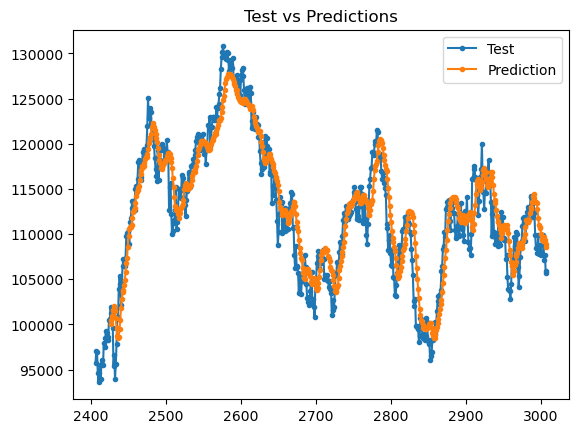

In [85]:
# Plotting the results

plt.plot(test, 'o-', markersize =3, label = 'Test' )
plt.plot(preds, 'o-', markersize =3, label = 'Prediction' )
plt.legend()
plt.title('Test vs Predictions')

In [86]:
# Evaluating model quality

pred_error =  test.tail(582) - preds
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
mape = mean_absolute_percentage_error(test.tail(582),  preds)

print(f'MODEL: LSTM Univariate')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MODEL: LSTM Univariate
MAE: Close    2231.022377
dtype: float64
RMSE: Close    2744.972482
dtype: float64
MAPE: 0.020090499629465887


The Recurrent Neural Networks models perform very well for time series, MAPE of around 2% indicates a very good model.
One of the points to be observed in LSTM is that it is a more complex model (black box) and demands memory to process, which can be a limiting factor depending on the volume of data.
This model would be better suited for a short-term forecast as it needs the last 20 days to forecast the next one.

## 5.5 Model 05 | LSTM | Multivariate time series

The last model implemented was a model of Recurrent Neural Networks also with LSTM, but this time new variables were included to try to improve its performance.
The information added to the analysis were annual data from: GDP, foreign investment and lending rate.
Now we have a multivariate time series.

In [87]:
# Copying the dataset with another name to preserve the original dataset

ibov_multi = ibov_df.copy(deep=True)
ibov_multi.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,year,month
0,0,2011-01-03,69310.0,70471.0,69305.0,69962.0,69962.0,1862400.0,2011,1
1,1,2011-01-04,69962.0,70318.0,69560.0,70318.0,70318.0,2427200.0,2011,1
2,2,2011-01-05,70311.0,71173.0,69802.0,71091.0,71091.0,2309200.0,2011,1
3,3,2011-01-06,71093.0,71167.0,70469.0,70579.0,70579.0,2546000.0,2011,1
4,4,2011-01-07,70580.0,70783.0,69718.0,70057.0,70057.0,1761000.0,2011,1


In [88]:
# Cleaning the data and checking

ibov_multi = ibov_multi.drop(columns = ['index'], axis = 1)
ibov_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3008 non-null   datetime64[ns]
 1   Open       3008 non-null   float64       
 2   High       3008 non-null   float64       
 3   Low        3008 non-null   float64       
 4   Close      3008 non-null   float64       
 5   Adj Close  3008 non-null   float64       
 6   Volume     3008 non-null   float64       
 7   year       3008 non-null   int64         
 8   month      3008 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 211.6 KB


In [89]:
# Merging historical data from ibovespa with data obtained from 
# the world bank and loaded at the beginning of this notebook

full_df = ibov_multi.merge(wb_df, on='year', how='left')
full_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,time,Foreign_direct_investment,Foreign_direct_investment_GDP,Lending_interest_rate,GDP_Current,GDP_Growth,GDP_Per_Capita
0,2011-01-03,69310.0,70471.0,69305.0,69962.0,69962.0,1862400.0,2011,1,YR2011,1.024272e+11,3.915112,43.883333,2.616202e+12,3.974423,15271.469352
1,2011-01-04,69962.0,70318.0,69560.0,70318.0,70318.0,2427200.0,2011,1,YR2011,1.024272e+11,3.915112,43.883333,2.616202e+12,3.974423,15271.469352
2,2011-01-05,70311.0,71173.0,69802.0,71091.0,71091.0,2309200.0,2011,1,YR2011,1.024272e+11,3.915112,43.883333,2.616202e+12,3.974423,15271.469352
3,2011-01-06,71093.0,71167.0,70469.0,70579.0,70579.0,2546000.0,2011,1,YR2011,1.024272e+11,3.915112,43.883333,2.616202e+12,3.974423,15271.469352
4,2011-01-07,70580.0,70783.0,69718.0,70057.0,70057.0,1761000.0,2011,1,YR2011,1.024272e+11,3.915112,43.883333,2.616202e+12,3.974423,15271.469352


In [90]:
# Keeping just the columns that will be used and dropping null values
# The world bank just has data until 2021

final_df = full_df.drop(['year','month','time','GDP_Current', 'Foreign_direct_investment_GDP', 'GDP_Growth', 'Open','High', 'Low', 'Adj Close','Volume'], axis=1).dropna()
final_df.head()

,Date,Close,Foreign_direct_investment,Lending_interest_rate,GDP_Per_Capita
0,2011-01-03,69962.0,1.024272e+11,43.883333,15271.469352
1,2011-01-04,70318.0,1.024272e+11,43.883333,15271.469352
2,2011-01-05,71091.0,1.024272e+11,43.883333,15271.469352
3,2011-01-06,70579.0,1.024272e+11,43.883333,15271.469352
4,2011-01-07,70057.0,1.024272e+11,43.883333,15271.469352


In [91]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2719 entries, 0 to 2718
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       2719 non-null   datetime64[ns]
 1   Close                      2719 non-null   float64       
 2   Foreign_direct_investment  2719 non-null   float64       
 3   Lending_interest_rate      2719 non-null   float64       
 4   GDP_Per_Capita             2719 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 127.5 KB


In [92]:
# Reseting the index because we dropped rows

final_df = final_df.reset_index()
final_df = final_df.drop(columns = ['index'], axis = 1)
final_df.head()

,Date,Close,Foreign_direct_investment,Lending_interest_rate,GDP_Per_Capita
0,2011-01-03,69962.0,1.024272e+11,43.883333,15271.469352
1,2011-01-04,70318.0,1.024272e+11,43.883333,15271.469352
2,2011-01-05,71091.0,1.024272e+11,43.883333,15271.469352
3,2011-01-06,70579.0,1.024272e+11,43.883333,15271.469352
4,2011-01-07,70057.0,1.024272e+11,43.883333,15271.469352


In [93]:
# Setting the date as index

final_df.set_index(pd.to_datetime(final_df.Date),inplace=True) 
final_df.drop('Date', axis = 1, inplace = True)
final_df[-5:]

,Close,Foreign_direct_investment,Lending_interest_rate,GDP_Per_Capita
Date,,,,
2021-12-23,104891.0,4.643907e+10,30.016667,14592.35296
2021-12-27,105531.0,4.643907e+10,30.016667,14592.35296
2021-12-28,104864.0,4.643907e+10,30.016667,14592.35296
2021-12-29,104107.0,4.643907e+10,30.016667,14592.35296
2021-12-30,104822.0,4.643907e+10,30.016667,14592.35296


In [94]:
# Indexing 
train_df = final_df.sort_values(by=['Date']).copy()

# List of Features
FEATURES = ['Close', 'Foreign_direct_investment', 'Lending_interest_rate', 'GDP_Per_Capita']


# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']


In [95]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to array
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Scaling the features 
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2719, 4)


In [96]:
# Set the sequence length - this is the timeframe used to make a single prediction

sequence_length = 10

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close]) 

    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)


In [97]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

40 10 4


In [98]:
# Training the model
# normally at least 50 epochs are used in this type of projection

epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/50
136/136 [==============================] - 7s 17ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 2/50
136/136 [==============================] - 2s 12ms/step - loss: 4.4532e-04 - val_loss: 0.0026
Epoch 3/50
136/136 [==============================] - 2s 12ms/step - loss: 4.3709e-04 - val_loss: 0.0020
Epoch 4/50
136/136 [==============================] - 2s 12ms/step - loss: 4.8866e-04 - val_loss: 0.0018
Epoch 5/50
136/136 [==============================] - 2s 12ms/step - loss: 3.9348e-04 - val_loss: 0.0017
Epoch 6/50
136/136 [==============================] - 2s 12ms/step - loss: 4.1843e-04 - val_loss: 0.0017
Epoch 7/50
136/136 [==============================] - 1s 9ms/step - loss: 4.1242e-04 - val_loss: 0.0017
Epoch 8/50
136/136 [==============================] - 3s 20ms/step - loss: 4.1367e-04 - val_loss: 0.0016
Epoch 9/50
136/136 [==============================] - 3s 22ms/step - loss: 3.5894e-04 - val_loss: 0.0021
Epoch 10/50
136/136 [==============================] - 2s 13

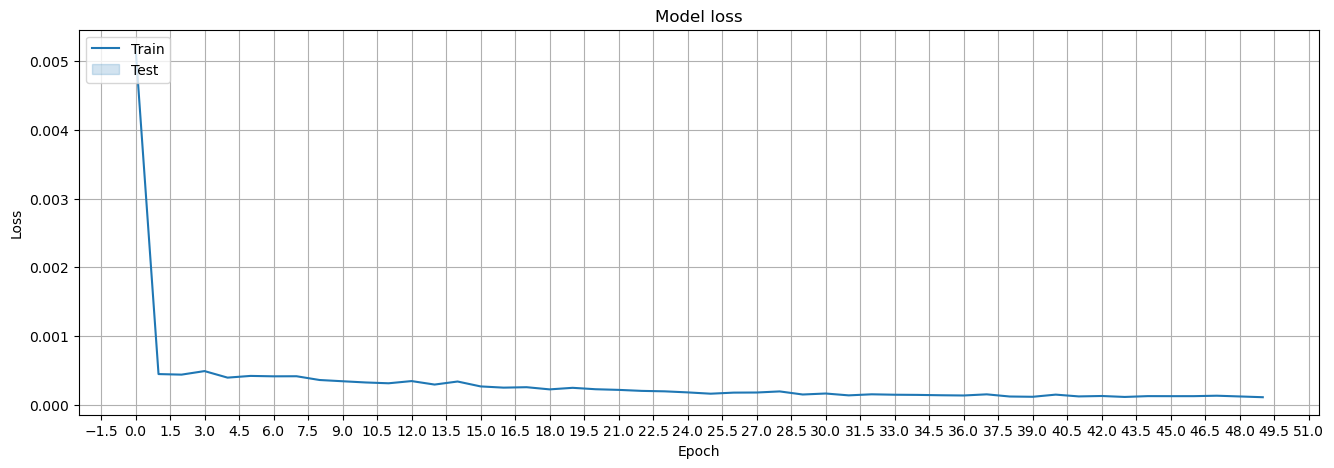

In [99]:
# Plot training & validation loss values

import seaborn as sns # Visualization

fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

As can be seen in the loss x epochs chart above, approximately from epoch 21 we do not have a significant reduction in losses.

In [100]:
# Predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))


pred_error =  y_test_unscaled - y_pred
mae = mean_absolute_error(y_test_unscaled, y_pred)
rmse = np.sqrt((pred_error**2).mean())
mape = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)))

print(f'MODEL: LSTM Univariate')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

17/17 [==============================] - 1s 5ms/step
MODEL: LSTM Univariate
MAE: 1415.0706721915283
RMSE: 2069.557123405234
MAPE: 0.0140998407983652


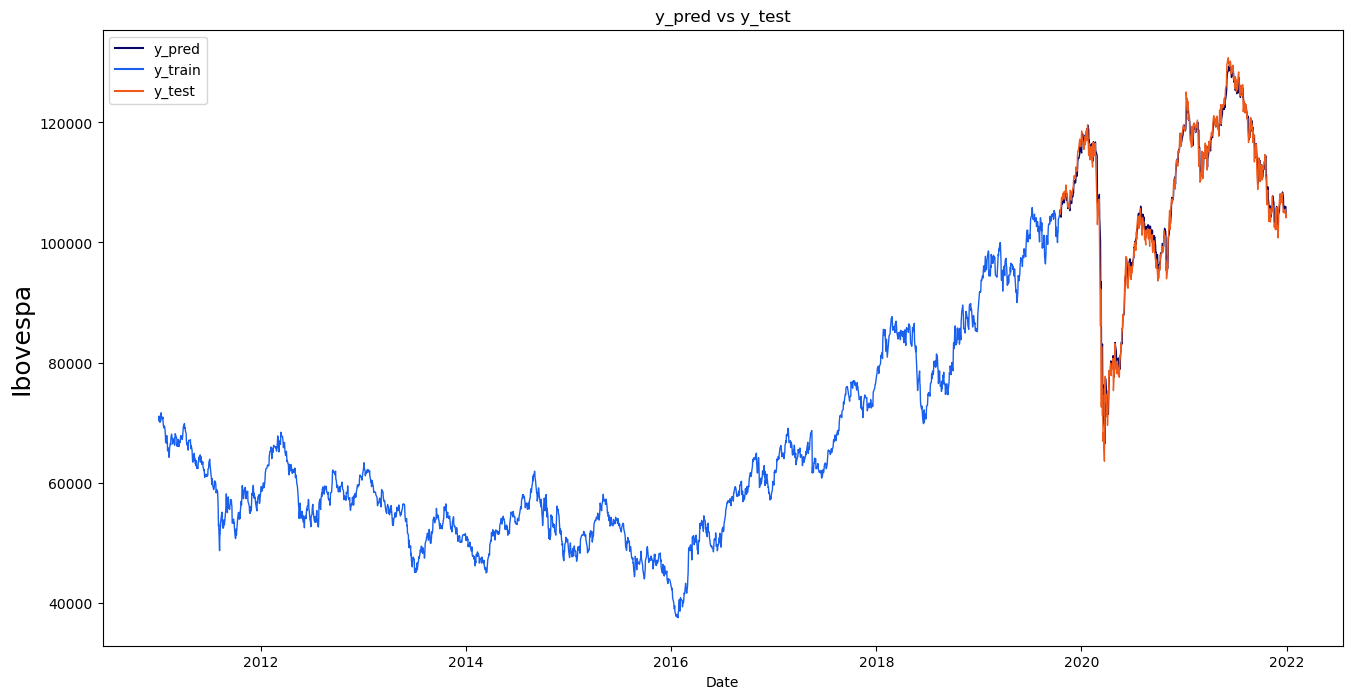

In [101]:
# The date from which on the date is displayed
display_start_date = "2011-01-03" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel('Ibovespa', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

plt.legend()
plt.show()

In [102]:
df_temp = final_df[-sequence_length:]
new_df = df_temp.filter(FEATURES)
end_date =  '2021-12-30'
N = sequence_length
new_df

,Close,Foreign_direct_investment,Lending_interest_rate,GDP_Per_Capita
Date,,,,
2021-12-16,108212.0,4.643907e+10,30.016667,14592.35296
2021-12-17,107201.0,4.643907e+10,30.016667,14592.35296
2021-12-20,105020.0,4.643907e+10,30.016667,14592.35296
2021-12-21,105500.0,4.643907e+10,30.016667,14592.35296
2021-12-22,105244.0,4.643907e+10,30.016667,14592.35296
2021-12-23,104891.0,4.643907e+10,30.016667,14592.35296
2021-12-27,105531.0,4.643907e+10,30.016667,14592.35296
2021-12-28,104864.0,4.643907e+10,30.016667,14592.35296
2021-12-29,104107.0,4.643907e+10,30.016667,14592.35296


In [103]:
# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

In [104]:
# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for Ibovespa at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 43ms/step
The close price for Ibovespa at 2021-12-30 was 104822.0
The predicted close price is 105304.921875 (+0.46%)


The historical series used in this model was shorter, given that the current The World Bank annuals used were only available up to 2021, so we had to discard the years 2022 and 2023 from the analysis.
This model had the best performance, MAPE around 1.5%. This model predicts the next day based on the last 10 days, given this characteristic its use should be for short-term projections.
One of the disadvantages is its complex implementation.